# Plotting Custom Metric Results


In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import os

import sae_bench.sae_bench_utils.general_utils as general_utils
import sae_bench.sae_bench_utils.graphing_utils as graphing_utils
from sae_bench.sae_bench_utils.sae_selection_utils import select_saes_multiple_patterns

# SAE Bench Plot Generator

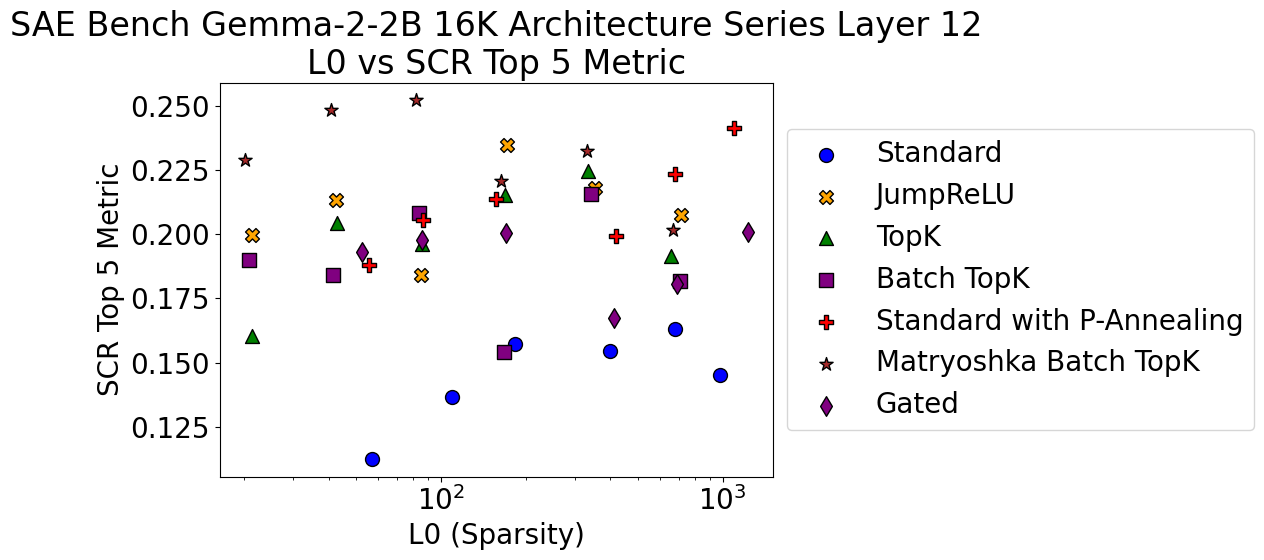

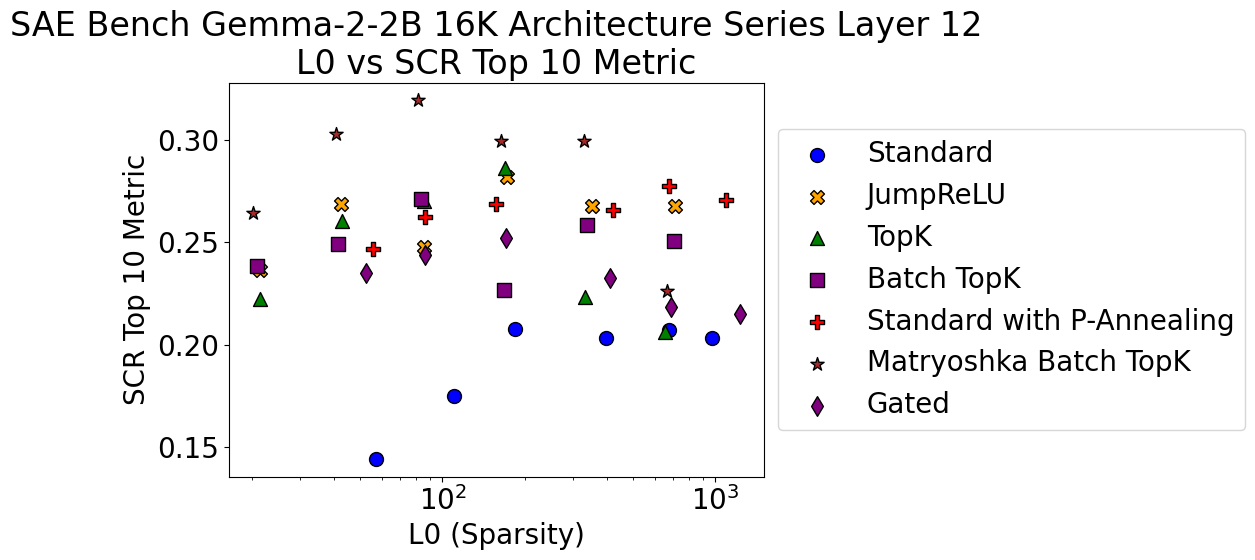

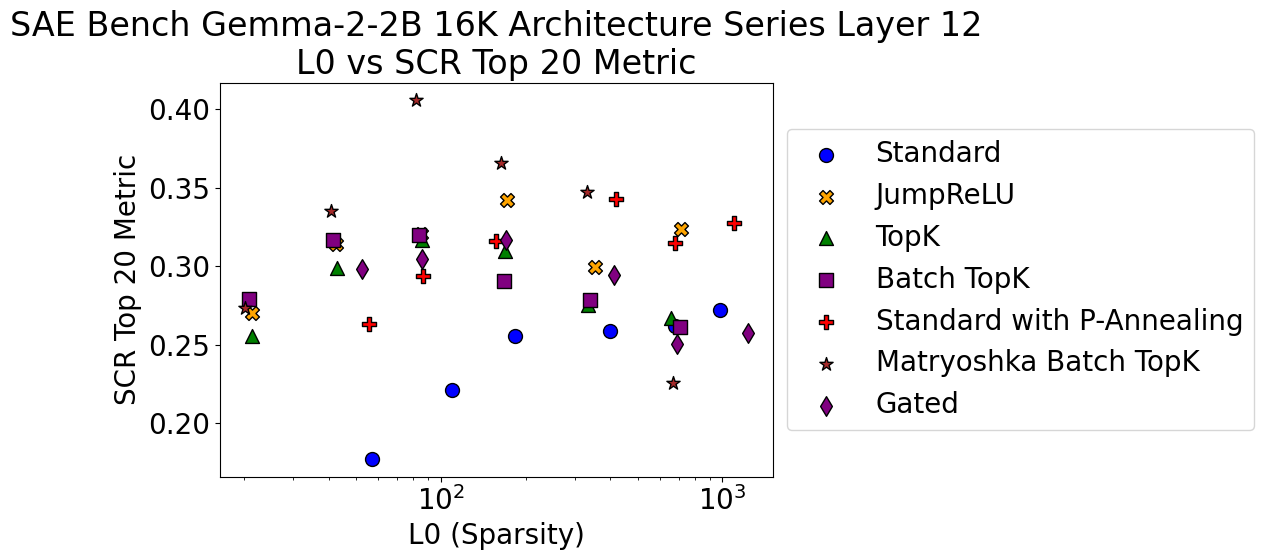

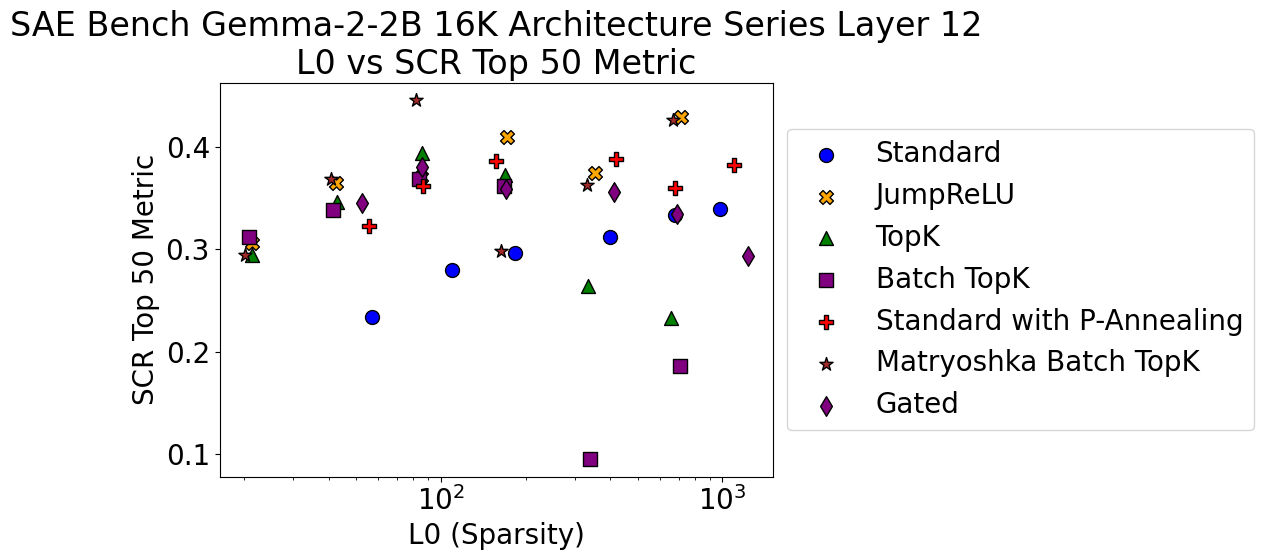

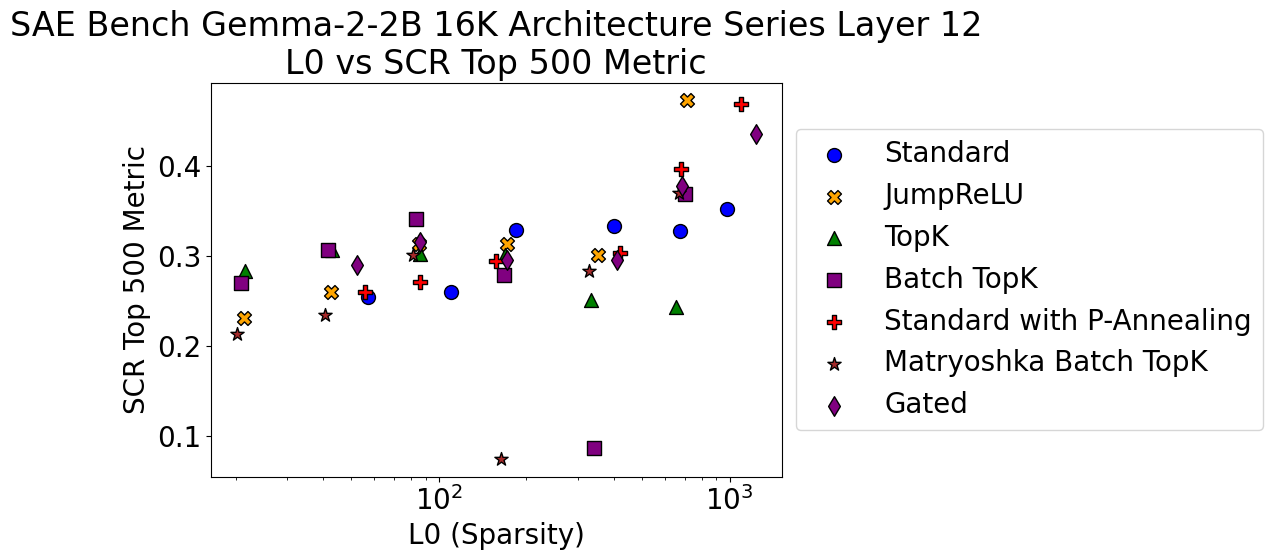

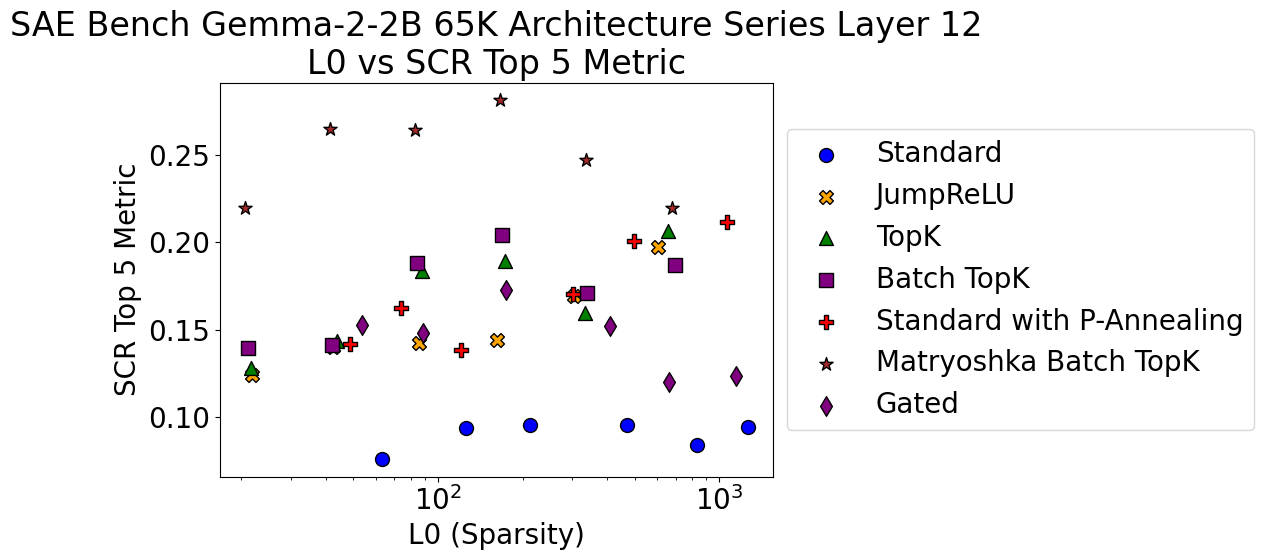

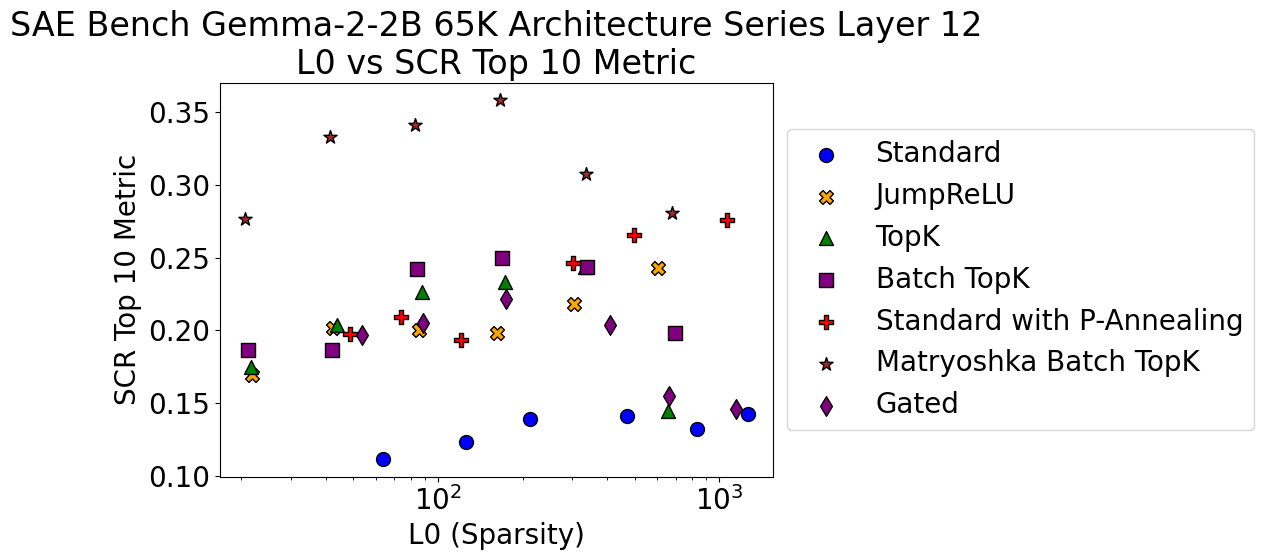

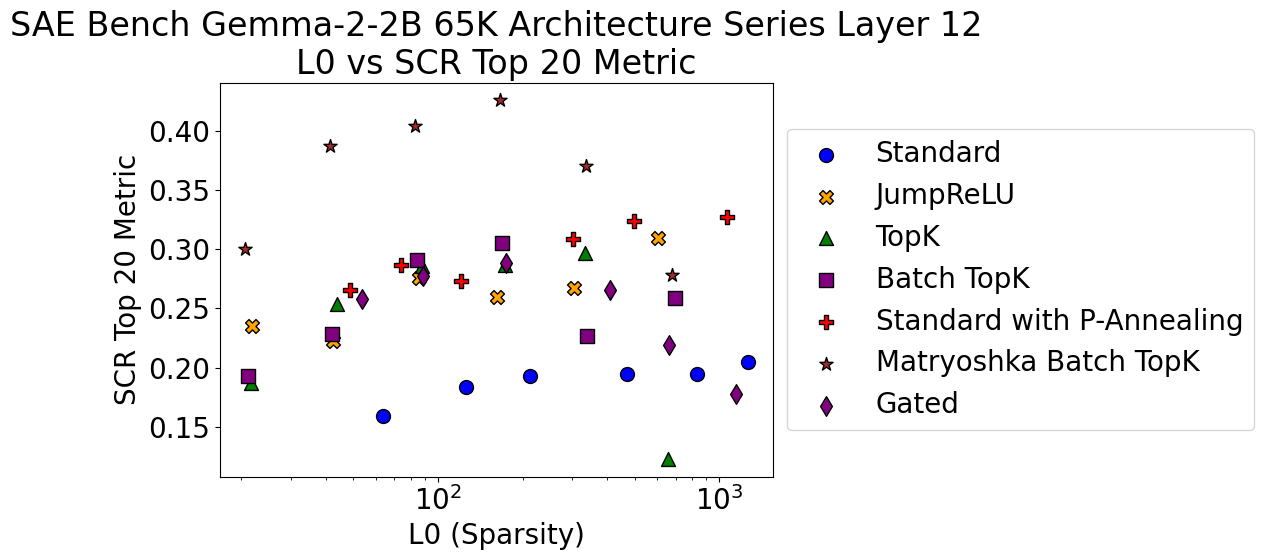

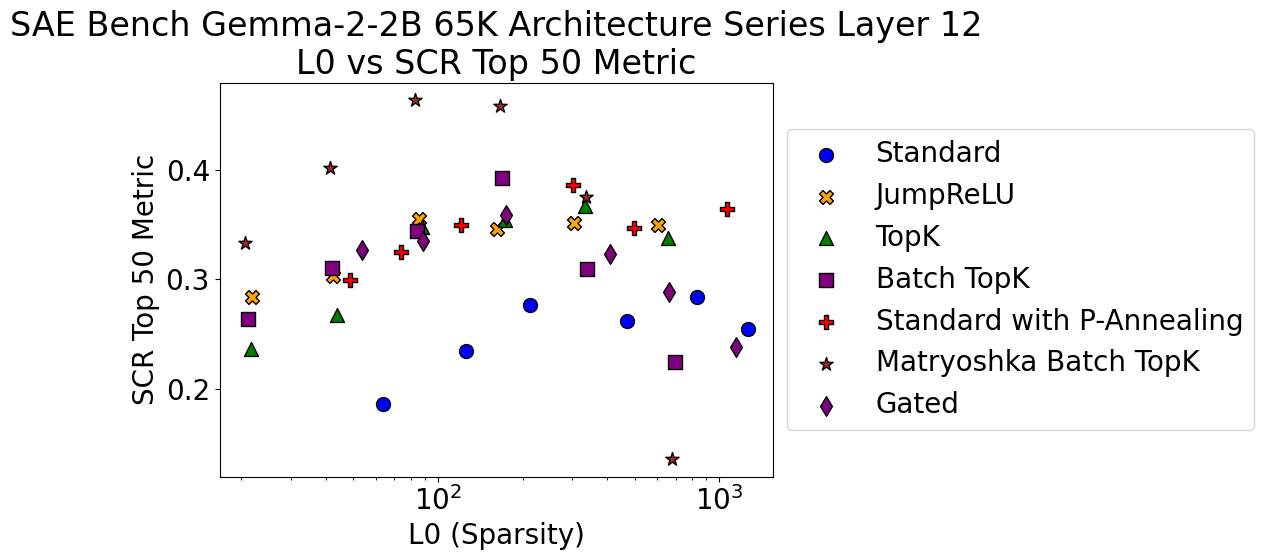

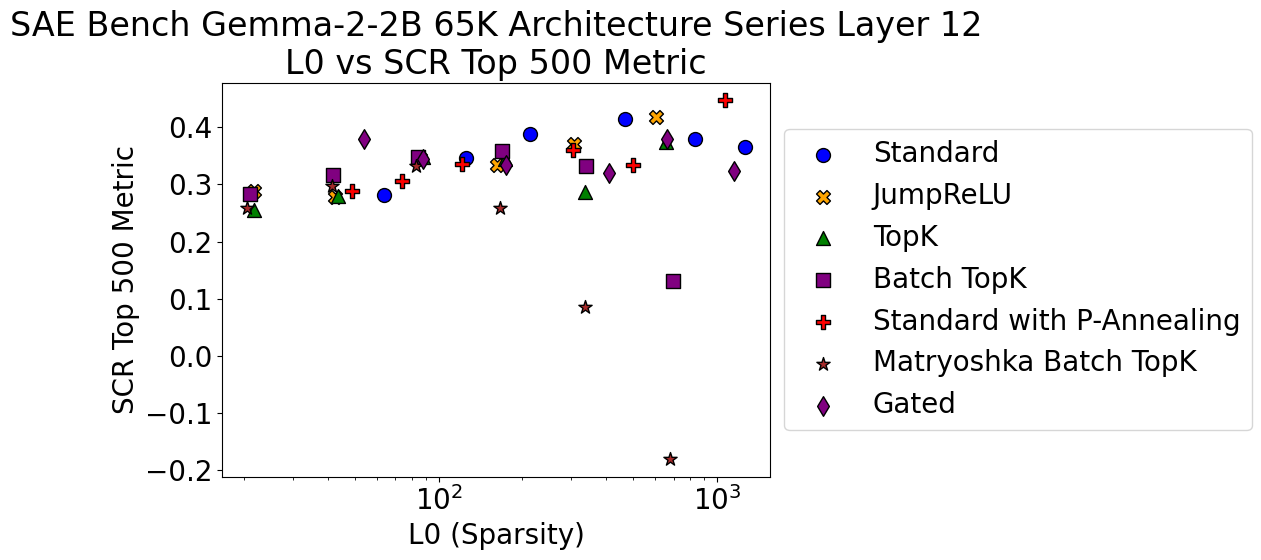

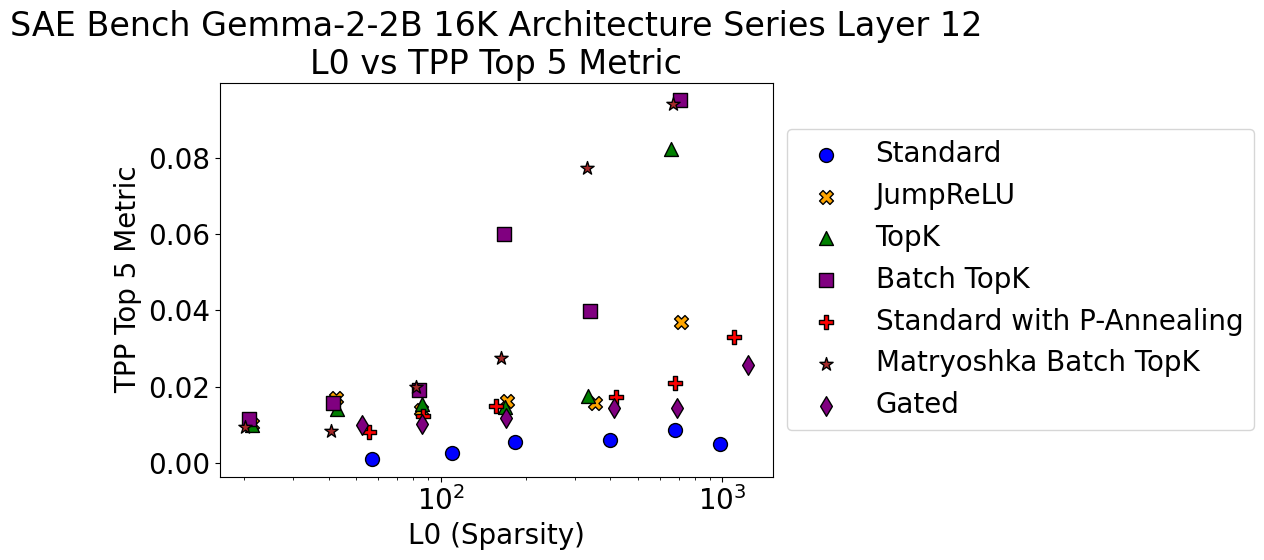

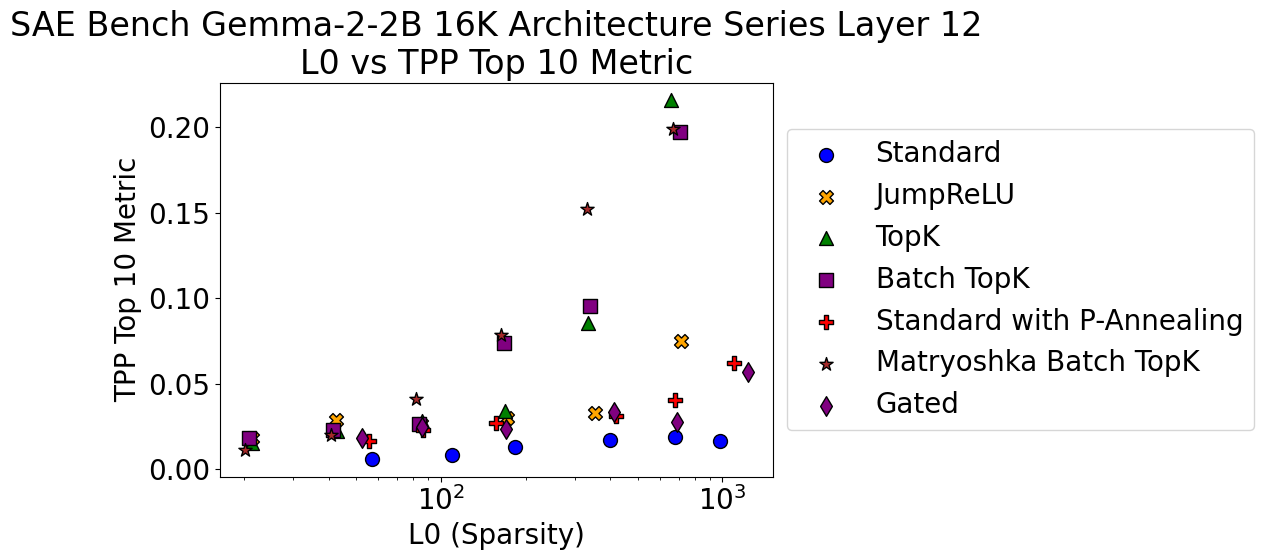

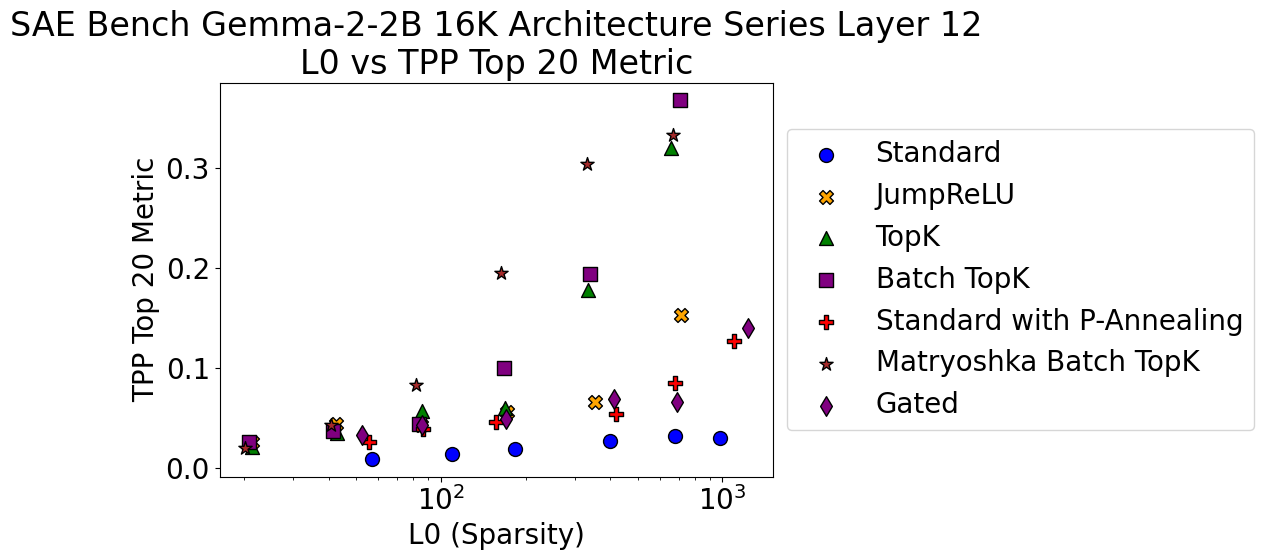

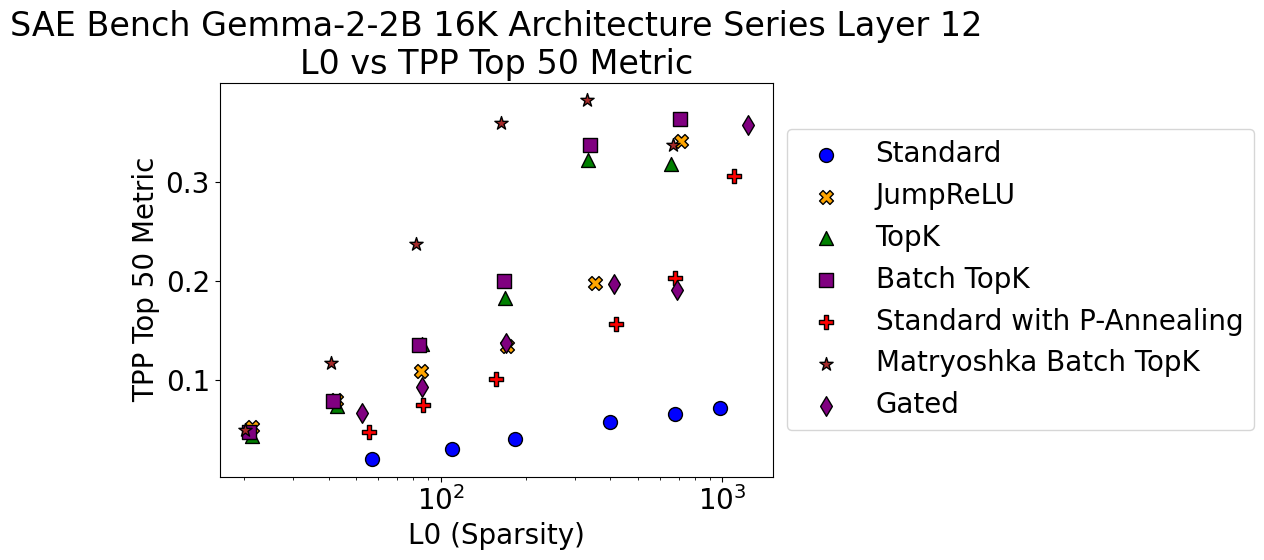

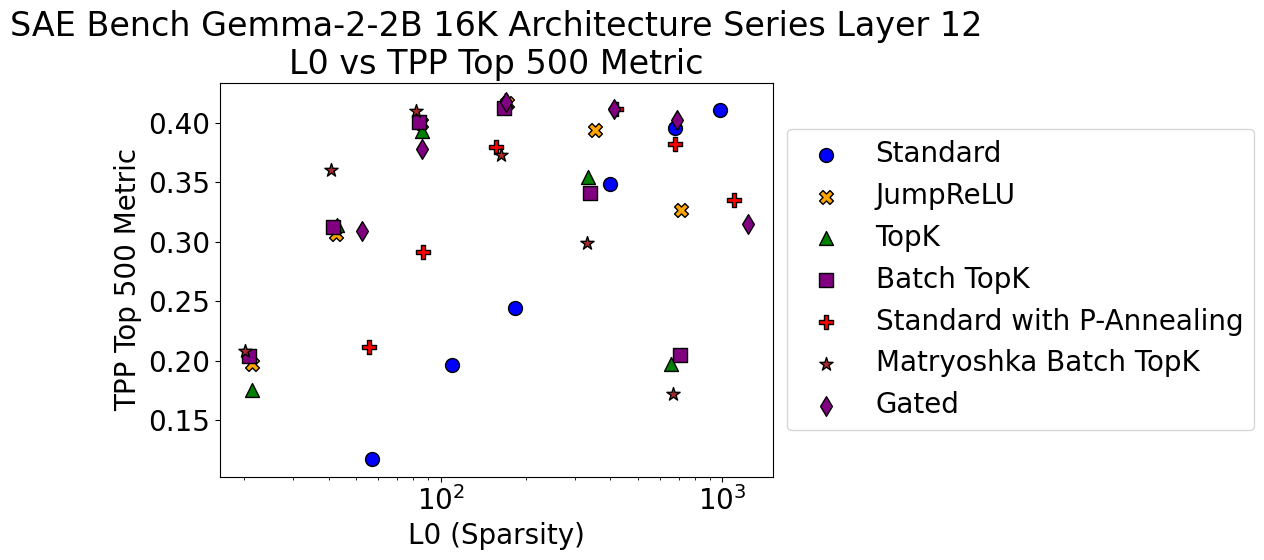

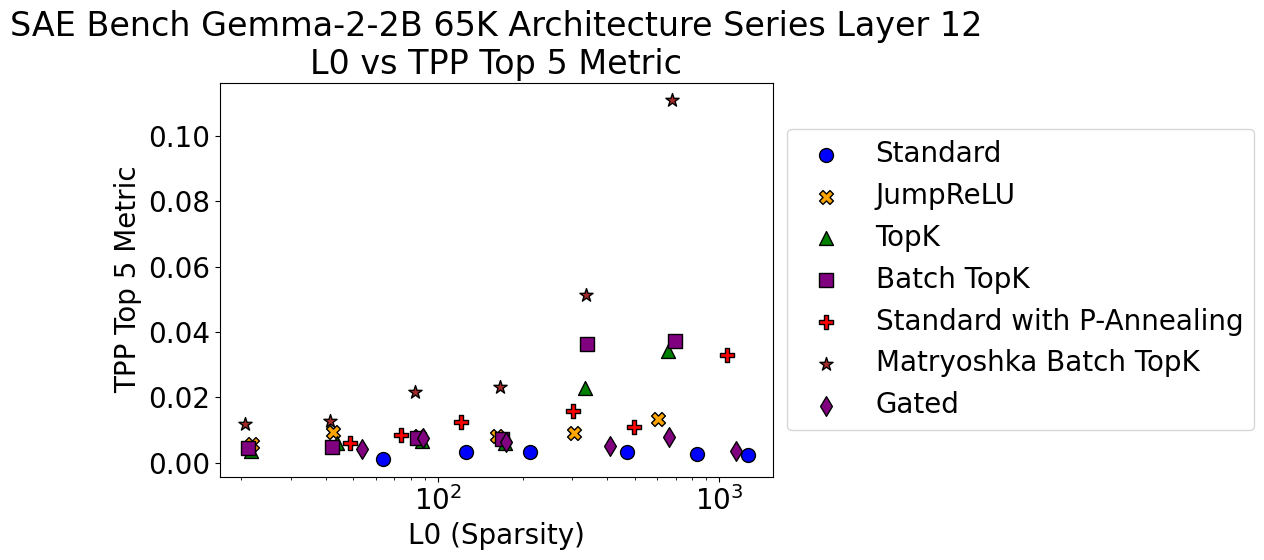

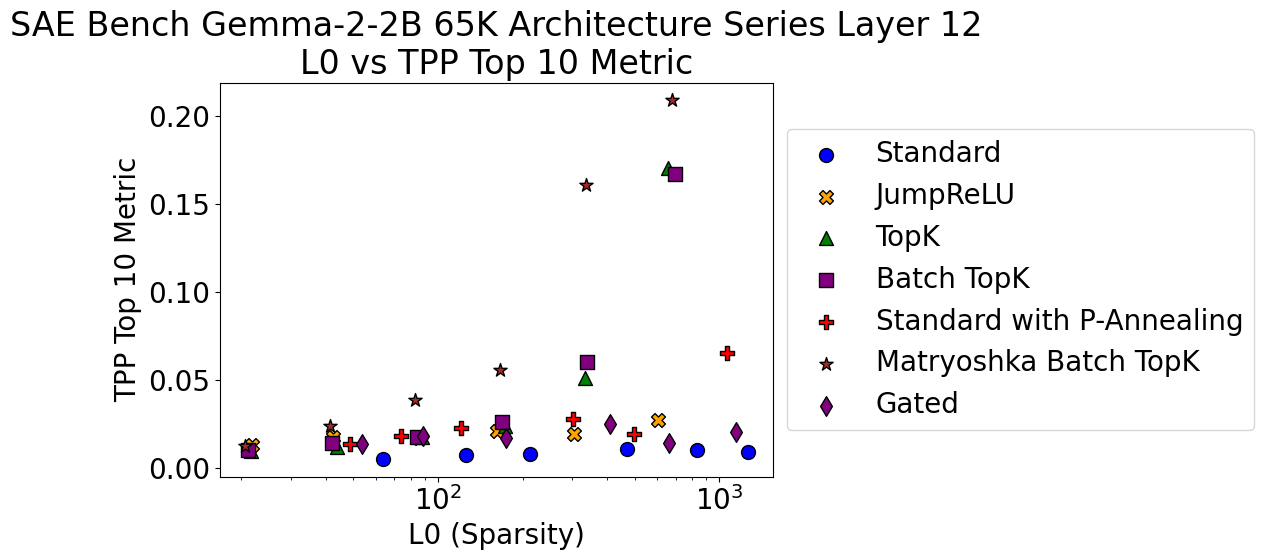

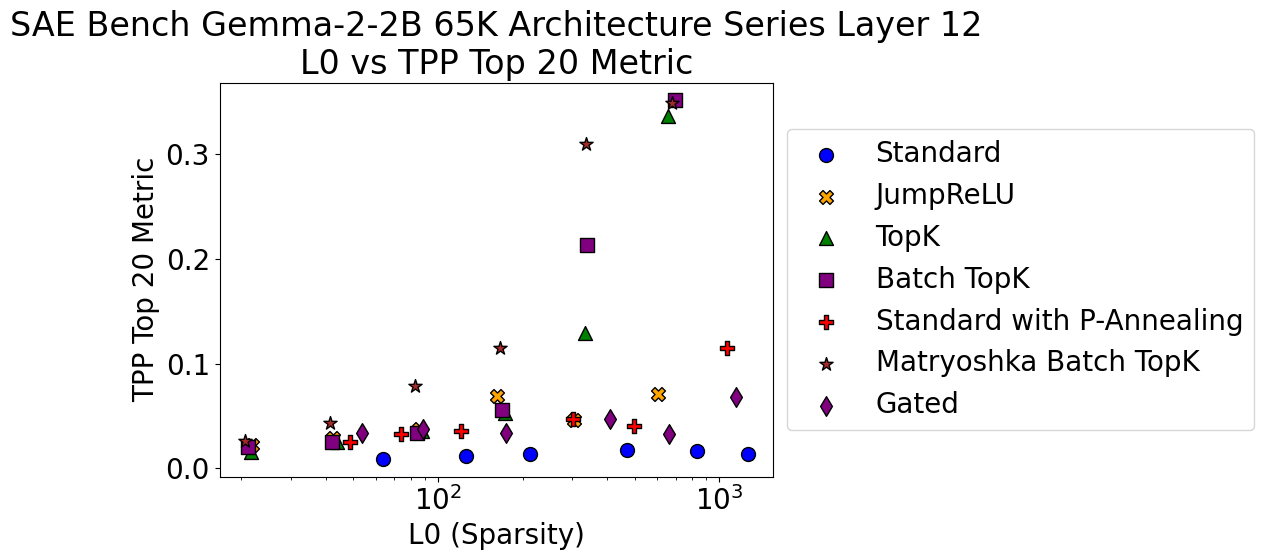

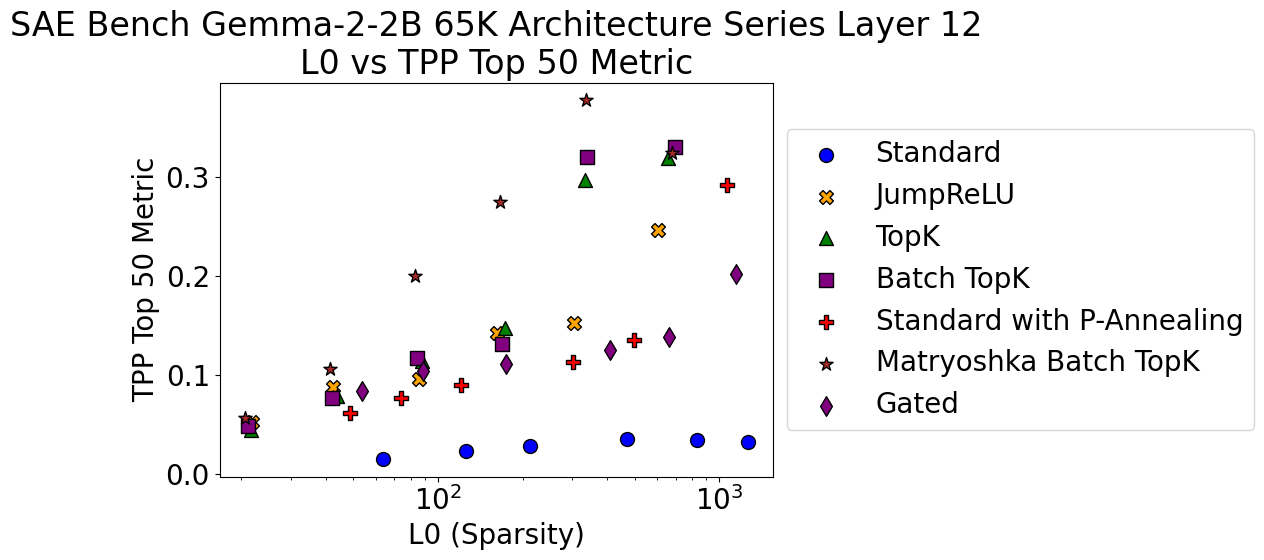

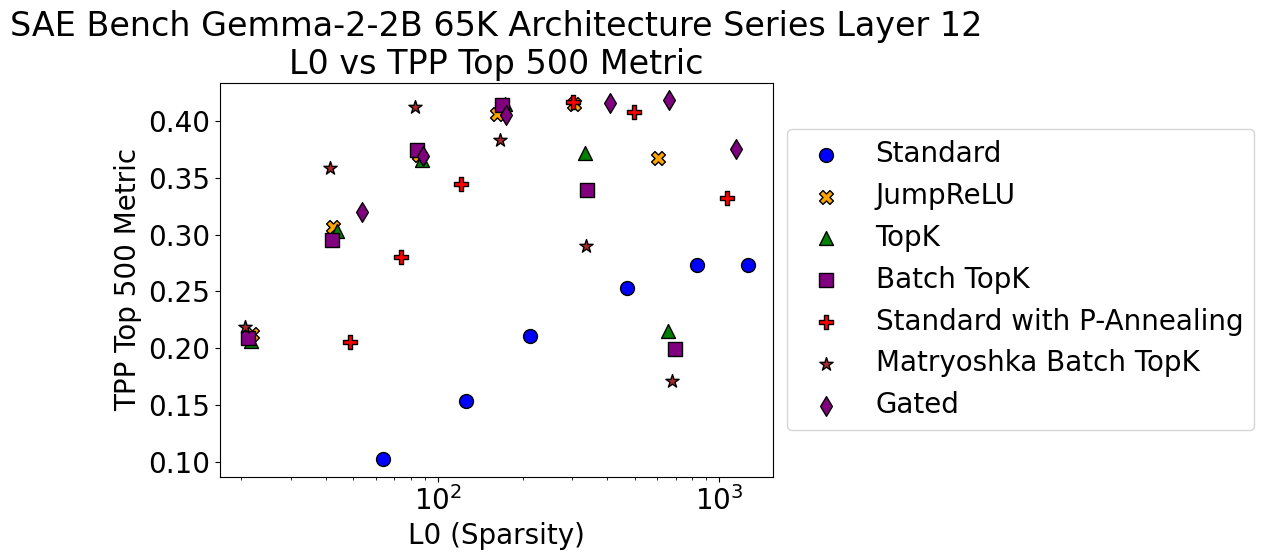

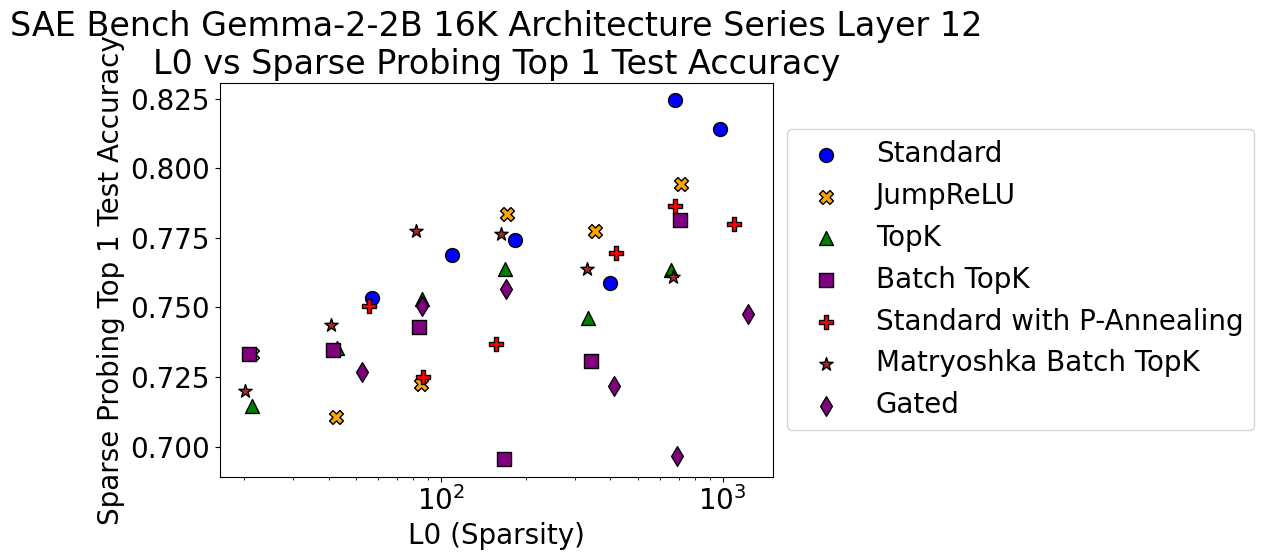

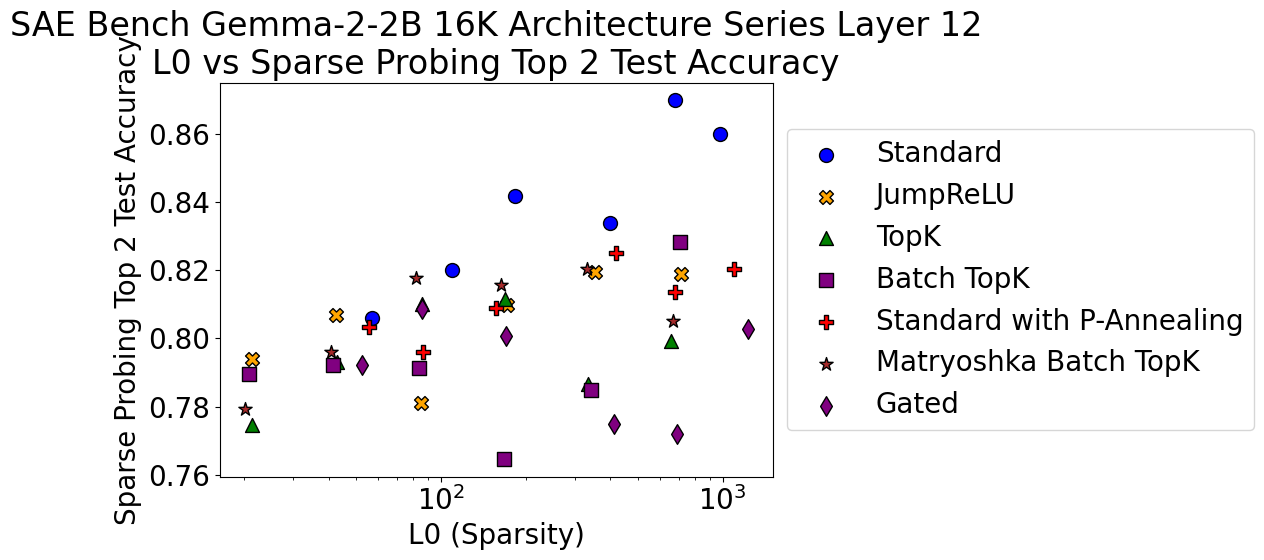

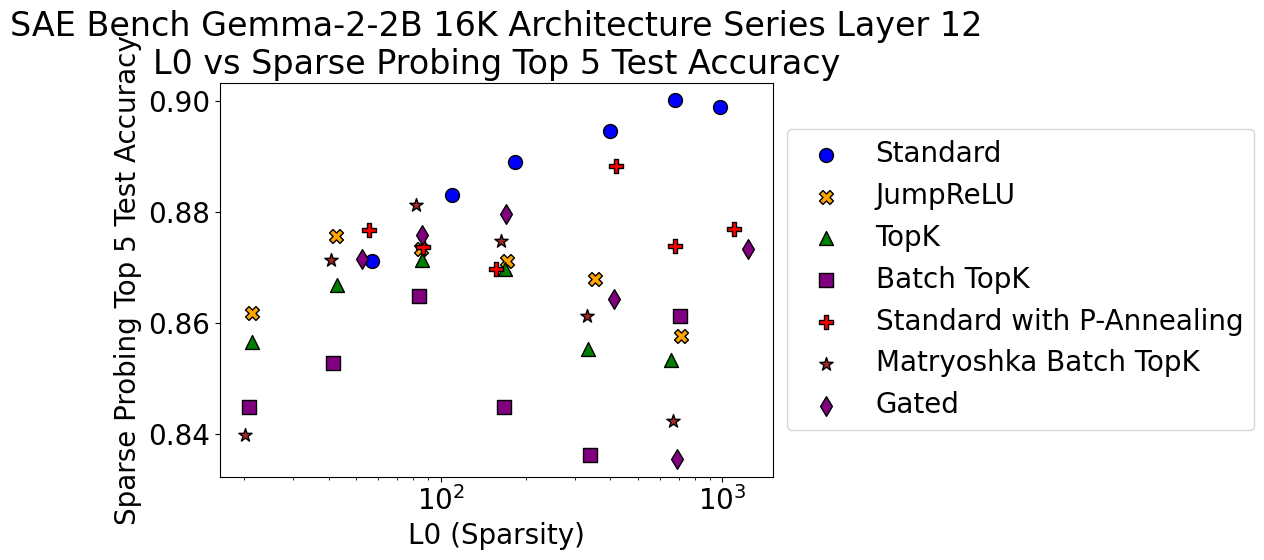

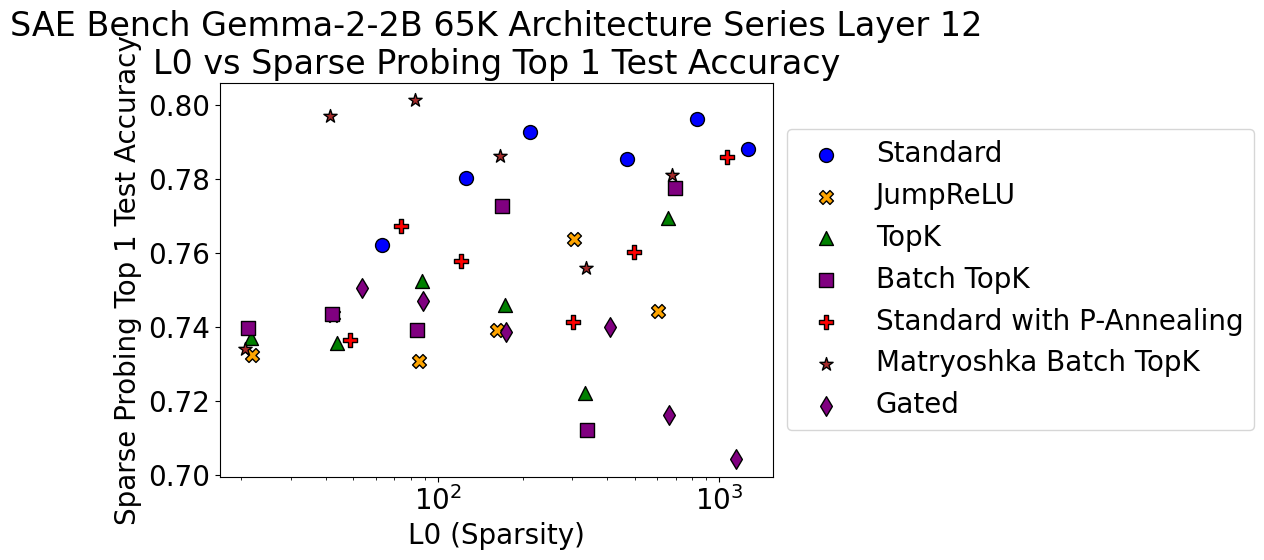

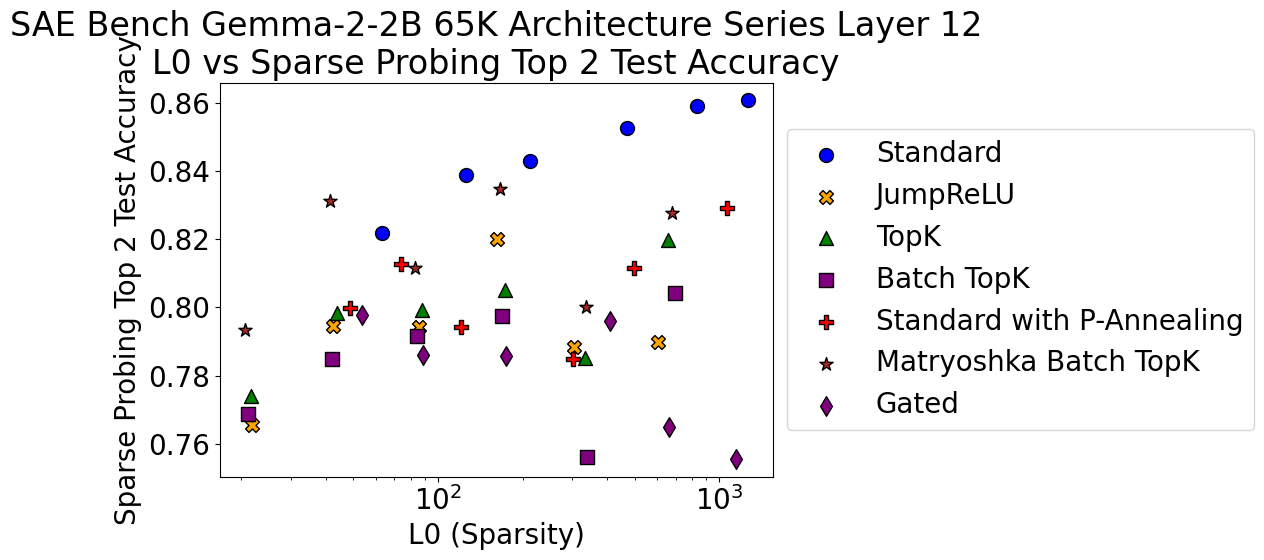

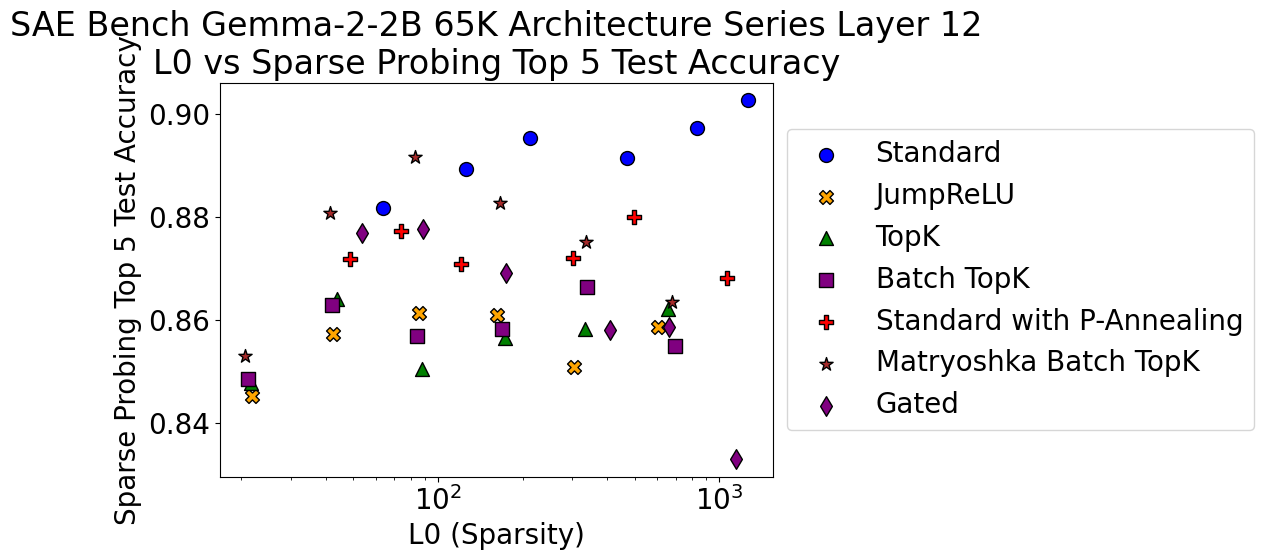

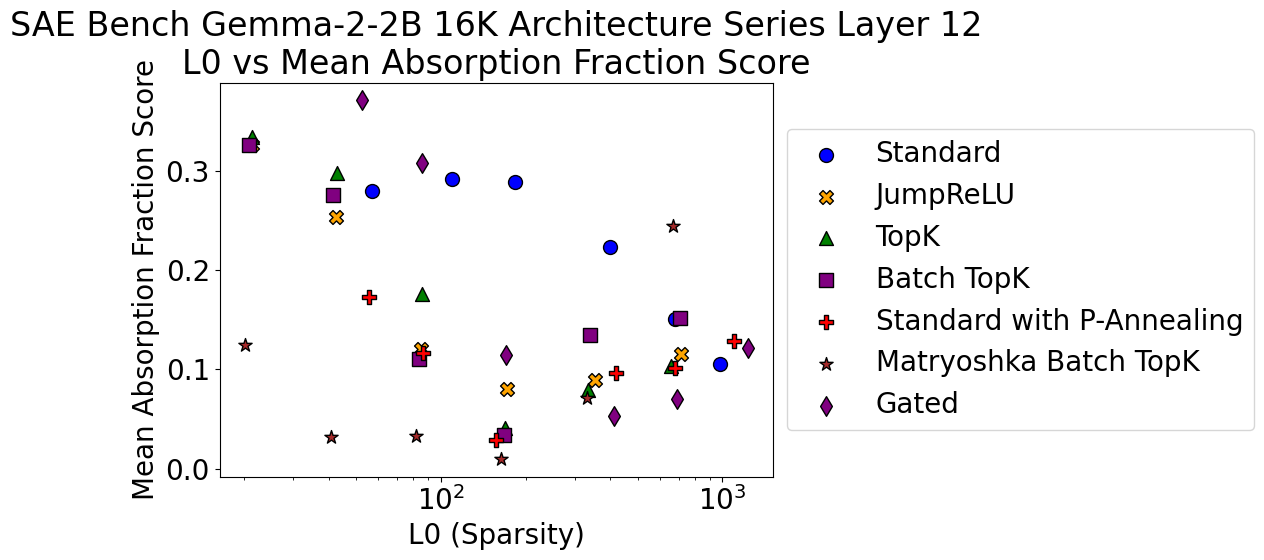

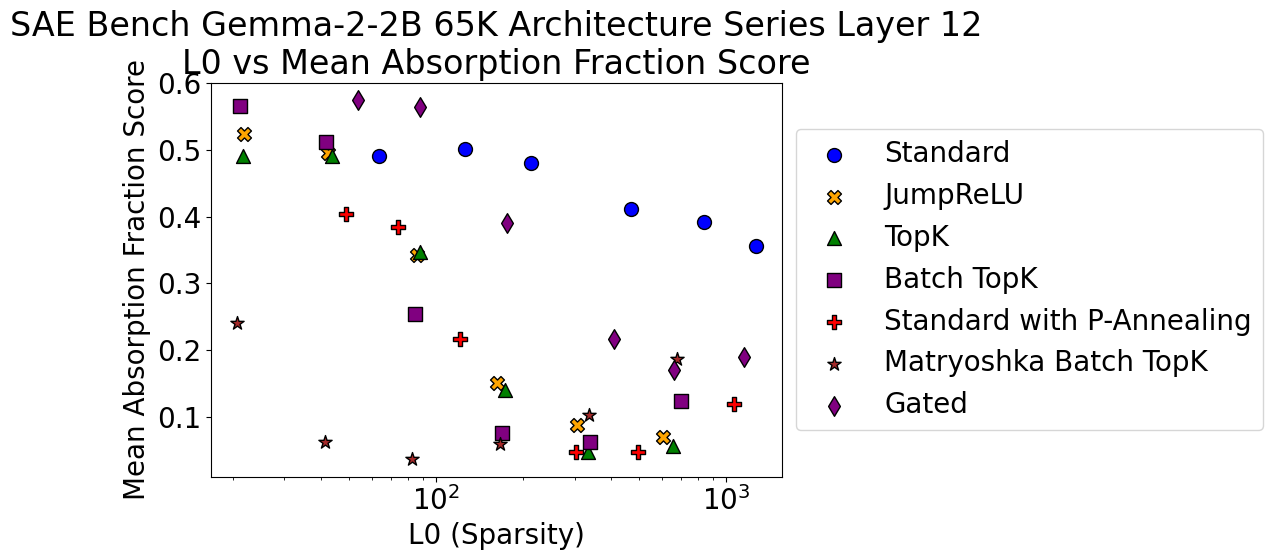

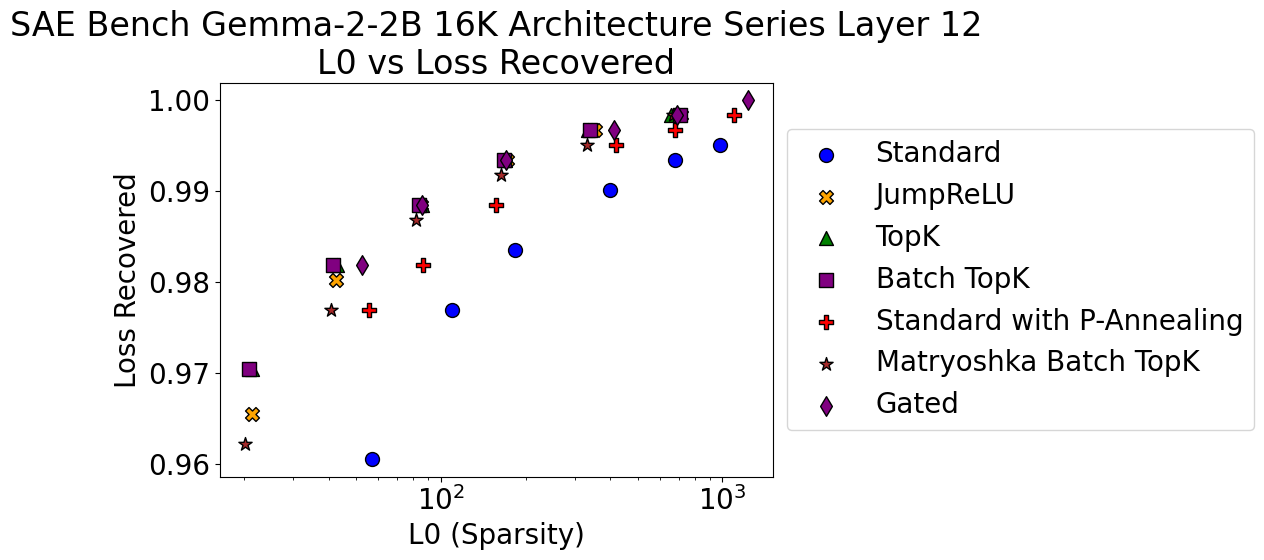

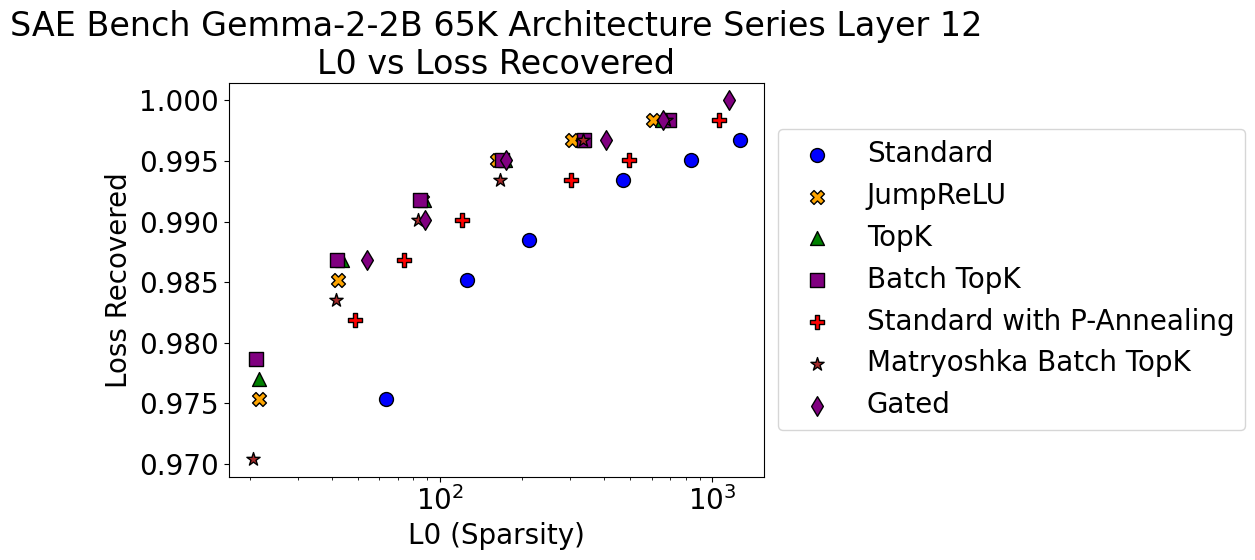

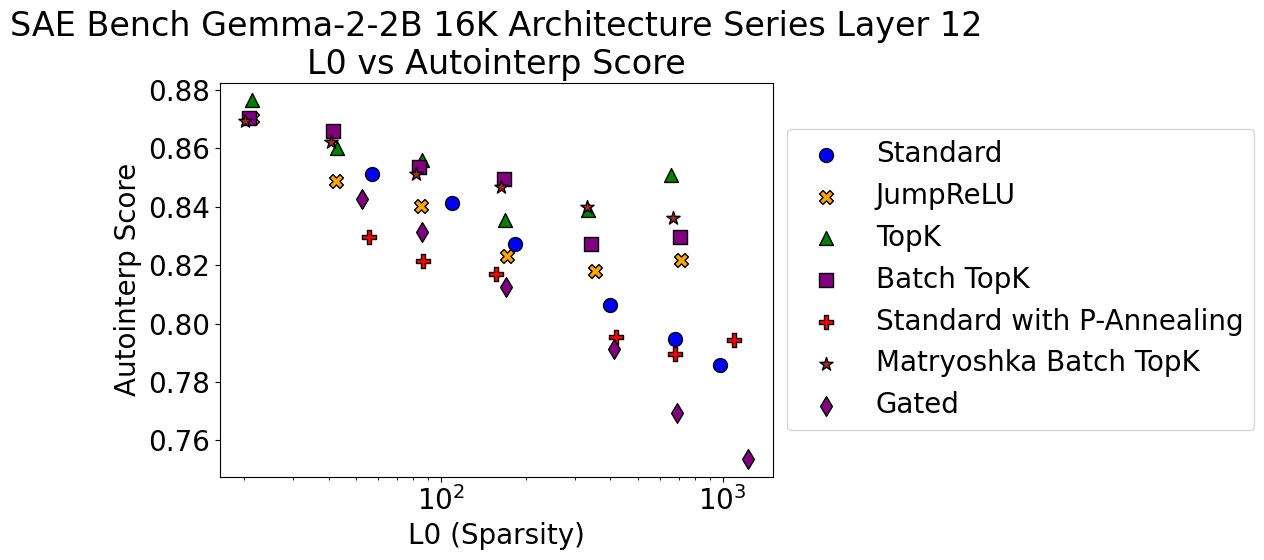

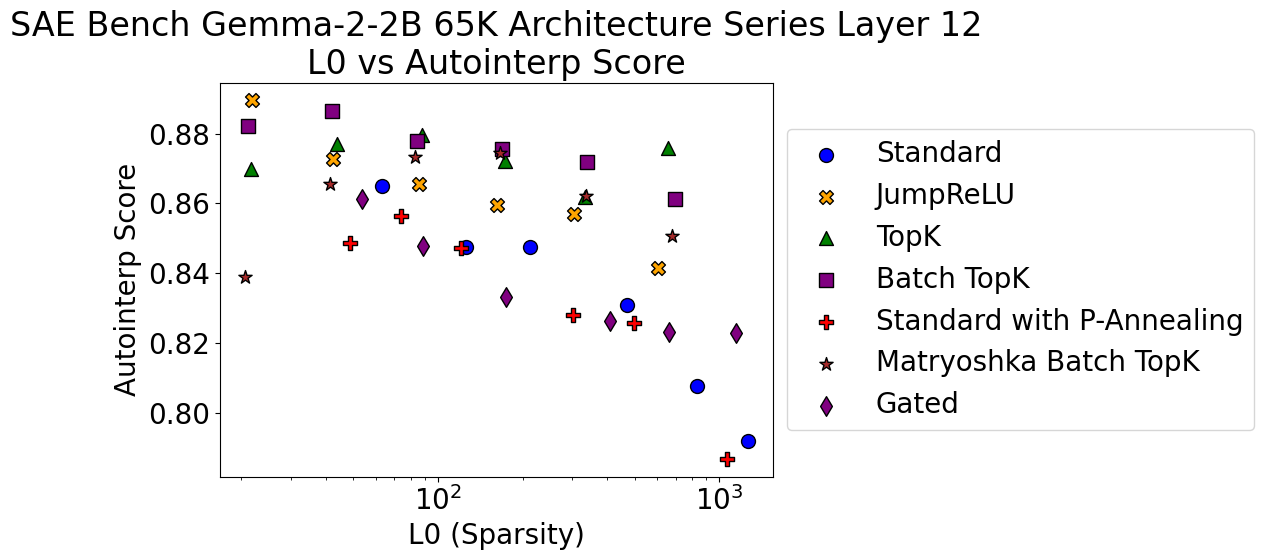

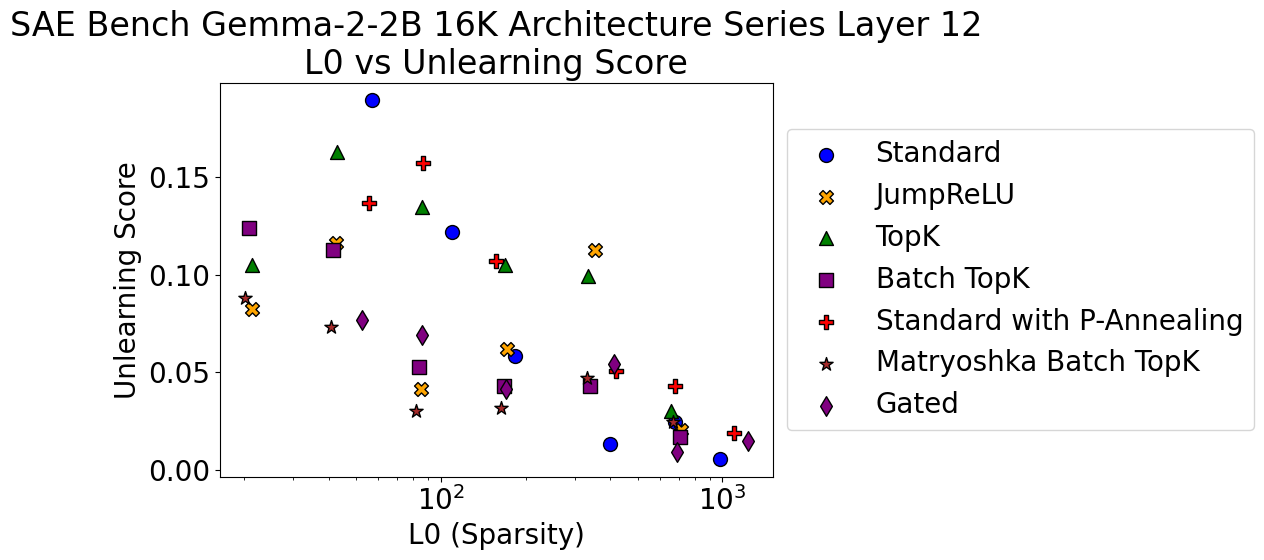

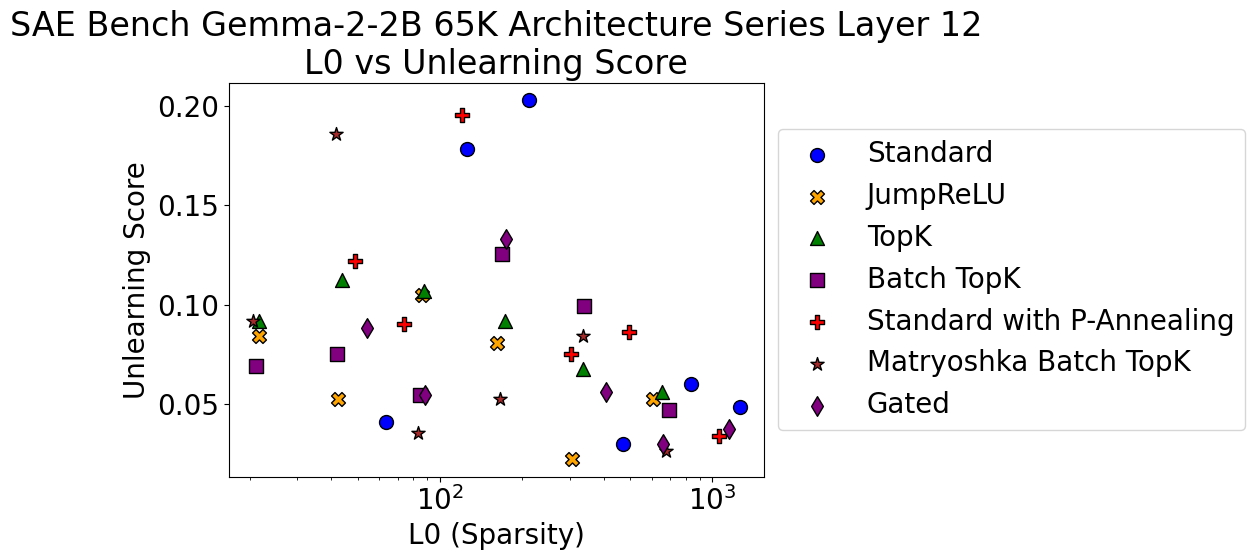

In [12]:
import itertools
import os

import sae_bench.sae_bench_utils.general_utils as general_utils
import sae_bench.sae_bench_utils.graphing_utils as graphing_utils

selections = {
    # "Gemma-Scope Gemma-2-2B Width Series": [
    #     r"gemma-scope-2b-pt-res_layer_{layer}_width_(16k|65k|1m)",
    # ],
    # "Gemma-Scope Gemma-2-9B Width Series": [
    #     r"gemma-scope-9b-pt-res_layer_{layer}_width_(16k|131k|1m)",
    # ],
    # "SAE Bench Gemma-2-2B Width Series": [
    #     r"saebench_gemma-2-2b_width-2pow12_date-0108.*(batch|Batch).*(?!.*step)(?!.*Standard).*",
    #     r"saebench_gemma-2-2b_width-2pow14_date-0108.*(batch|Batch).*(?!.*step)(?!.*Standard).*",
    #     r"saebench_gemma-2-2b_width-2pow16_date-0108.*(batch|Batch).*(?!.*step)(?!.*Standard).*",
    # ],
    # "SAE Bench Gemma-2-2B Matryoshka Width Series": [
    #     r"matroyshka_gemma-2-2b-16k-v2_MatroyshkaBatchTopKTrainer_notemp.*",
    #     r"matroyshka_gemma-2-2b-16k-v2_MatryoshkaBatchTopKTrainer_65k_temp1000.*",
    # ],
    # "SAE Bench Gemma-2-2B 4K Width Series": [
    #     r"saebench_gemma-2-2b_width-2pow12_date-0108(?!.*step).*",
    # ],
    "SAE Bench Gemma-2-2B 16K Architecture Series": [
        r"saebench_gemma-2-2b_width-2pow14_date-0108(?!.*step).*",
        r"matroyshka_gemma-2-2b-16k-v2_MatroyshkaBatchTopKTrainer_notemp.*",
    ],
    "SAE Bench Gemma-2-2B 65K Architecture Series": [
        r"saebench_gemma-2-2b_width-2pow16_date-0108(?!.*step).*",
        r"matroyshka_gemma-2-2b-16k-v2_MatryoshkaBatchTopKTrainer_65k_temp1000.*",
    ],
    # "SAE Bench Pythia-70M SAE Type Series": [
    #     r"sae_bench_pythia70m_sweep.*_ctx128_.*blocks\.({layer})\.hook_resid_post__trainer_.*",
    # ],
}

results_folders = ["./graphing_eval_results_0119", "./matroyshka_0117"]
baseline_folder = results_folders[0]

eval_type = "absorption"

eval_types = [
    "scr",
    "tpp",
    "sparse_probing",
    "absorption",
    "core",
    "autointerp",
    "unlearning",
]

combinations = list(itertools.product(eval_types, selections.keys()))

ks_lookup = {
    "scr": [5, 10, 20, 50, 500],
    "tpp": [5, 10, 20, 50, 500],
    "sparse_probing": [1, 2, 5],
}

baseline_type = "pca_sae"
include_baseline = False
image_path = "./images"


for eval_type, selection in combinations:
    if eval_type in ks_lookup:
        ks = ks_lookup[eval_type]
    else:
        ks = [-1]

    if "Gemma-2-2B" in selection:
        layers = [12]
        model_name = "gemma-2-2b"
    elif "Pythia-70M" in selection:
        layers = [3, 4]
        model_name = "pythia-70m-deduped"
    elif "Gemma-2-9B" in selection:
        layers = [9, 20, 31]
        model_name = "gemma-2-9b"
    else:
        raise ValueError("Please add the correct layers for the selection")

    layer_ks_combinations = list(itertools.product(layers, ks))

    for layer, k in layer_ks_combinations:
        sae_regex_patterns = selections[selection]

        for i, pattern in enumerate(sae_regex_patterns):
            sae_regex_patterns[i] = pattern.format(layer=layer)

        prefix = f"{selection} Layer {layer}\n"

        image_base_folder = os.path.join(image_path, eval_type)

        if not os.path.exists(image_base_folder):
            os.makedirs(image_base_folder)

        image_base_name = os.path.join(
            image_base_folder, f"{selection.replace(' ', '_').lower()}_layer_{layer}"
        )

        if eval_type in ks_lookup:
            image_base_name = f"{image_base_name}_topk_{k}"

        baseline_sae = None
        baseline_label = None

        if include_baseline:
            if model_name != "gemma-2-9b":
                baseline_sae = (
                    f"{model_name}_layer_{layer}_pca_sae_custom_sae_eval_results.json"
                )
                baseline_sae = os.path.join(baseline_folder, eval_type, baseline_sae)
                baseline_label = "PCA Baseline"

        eval_folders = []
        core_folders = []

        for results_folder in results_folders:
            eval_folders.append(f"{results_folder}/{eval_type}")
            core_folders.append(f"{results_folder}/core")

        eval_filenames = graphing_utils.find_eval_results_files(eval_folders)
        core_filenames = graphing_utils.find_eval_results_files(core_folders)
        
        filtered_eval_filenames = general_utils.filter_with_regex(
            eval_filenames, sae_regex_patterns
        )
        filtered_core_filenames = general_utils.filter_with_regex(
            core_filenames, sae_regex_patterns
        )

        # We will have failures on e.g. Pythia and unlearning, because the results don't exist
        try:
            graphing_utils.plot_results(
                filtered_eval_filenames,
                filtered_core_filenames,
                eval_type,
                image_base_name,
                k=k,
                title_prefix=prefix,
                baseline_sae_path=baseline_sae,
                baseline_label=baseline_label,
                plot_2var_dict=False,
                plot_2var_sae=True,
                plot_3var=False,
            )
        except Exception as e:
            print(f"Error plotting {selection} Layer {layer}: {str(e)}")
            continue
